## 1D Case - Figure 10
 
Comparison of residual loss

$$\tilde L_r = \frac{\lambda_1}{n_{\Omega}}\sum_{i=0}^{n_{\Omega}-1}\left( \nabla \cdot \underline{\underline{\sigma}}(\underline u) - \underline f \right)^2 
        + \frac{\lambda_2}{n_{\partial\Omega}}\sum_{i=0}^{n_{\partial\Omega}-1}\left( \underline{n} \cdot \underline{\underline{\sigma}}(u) - \underline t \right)^2$$,

 weak formulation loss 

$$L_r = \frac{\lambda_1}{n_{\Omega}}\sum_{i=0}^{n_{\Omega}-1}\left( \nabla \cdot \underline{\underline{\sigma}} - \underline f \right)^2 
        + \frac{\lambda_1}{n_{\Omega}}\sum_{i=0}^{n_{\Omega}-1}\left( \underline{\underline{\sigma}}(\underline u) - \underline{\underline{\sigma}} \right)^2 
        $$ 


and potential energy loss

$$L_p = \frac{1}{2}\int_\Omega \underline{\underline{\sigma}}(\underline u):\underline{\underline{\epsilon}}(\underline u) 
         - \int_\Omega\underline f \underline u
         - \int_{\partial\Omega_N} \underline t \underline u$$ 

In [1]:
#%% Libraries import
import sys  
# sys.path.append("../neurom/")

from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import neurom.src.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import Training funcitons
from neurom.src.Training import Training_1D_FEM_LBFGS, Training_1D_Mixed_LBFGS
#Import post processing libraries
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [3]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = 'Configuration/config_1D.toml'


with open(Default_config_file, mode="rb") as f:
    config = tomllib.load(f)

In [4]:
# Experiment setting: Potential energy loss
# 6 mesh resolutions, 5-point quadrature 

mesh_resolution_pe = [10,21,41,80,160]
loss_u_pe = numpy.zeros((len(mesh_resolution_pe)))
loss_grad_pe = numpy.zeros((len(mesh_resolution_pe)))

config["interpolation"]["n_integr_points"] = 5
config["solver"]["IntegralMethod"] = "Gaussian_quad"
config["solver"]["FrozenMesh"] = True

for res in range(len(mesh_resolution_pe)):

    config["interpolation"]["np"] = mesh_resolution_pe[res]
    

    # Load parameters
    if config["interpolation"]["dimension"] == 1:
        Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["E"],            # Young Modulus
                                        coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                            )
    elif config["interpolation"]["dimension"] == 2:
        try:
            Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["E"],            # Young Modulus
                                        coef2     = config["material"]["nu"]            # Poisson's ratio
                            )
        except:
            Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # First Lame's coef
                                        coef2     = config["material"]["mu"]            # Second Lame's coef
                            )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                )

    Excluded = []

    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh() 

    print(config["solver"]["IntegralMethod"])
    print()
    # Vtk file not necessary if not using reference element implementation
    if config["solver"]["IntegralMethod"] == "Gaussian_quad":
        Mesh_object.ExportMeshVtk1D()

    # Build the assembly weight matrix if needed
    if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
        Mesh_object.AssemblyMatrix()                                            

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    if config["solver"]["TrainingStrategy"]=="Integral":
        match config["solver"]["IntegralMethod"]:                          
            case "Gaussian_quad":
                Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
            case "Trapezoidal":
                Model_FEM = MeshNN(Mesh_object)

    if config["solver"]["TrainingStrategy"]=="Mixed":
        if config["solver"]["IntegralMethod"] == "Gaussian_quad":
            Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
            Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
            Model_test.Freeze_Mesh()

    # Default setting
    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh()    

    if config["solver"]["TrainingStrategy"]=="Mixed":
        Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
    else:
        Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

    loss_u_pe[res], loss_grad_pe[res] = Pplot.Normalized_error_1D(Model_FEM,config,Mat)



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v3.1.1

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           10
Gaussian_quad


mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.01360793404964395
     loss_decrease =  1.013607934049644
epoch =  2
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  3
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  4
     loss =  -

In [5]:
# Experiment setting: Weak formulation loss
# 4 mesh resolutions, 3-,4- and 5-point quadrature, fixed mesh

mesh_resolution_w = [10,21,41,80]
quadrature_points = [3,4,5]

loss_u_w = numpy.zeros((len(mesh_resolution_w),len(quadrature_points)))
loss_grad_w = numpy.zeros((len(mesh_resolution_w),len(quadrature_points)))

config["solver"]["TrainingStrategy"] = "Mixed"
config["solver"]["IntegralMethod"] = "Gaussian_quad"
config["solver"]["FrozenMesh"] = True

for res in range(len(mesh_resolution_w)):
    config["interpolation"]["np"] = mesh_resolution_w[res]
    for q in range(len(quadrature_points)):
        config["interpolation"]["n_integr_points"] = quadrature_points[q]

        # Load parameters
        Mat = pre.Material(     flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],        # Young Modulus
                                coef2     = config["material"]["A"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                    )

        Excluded = []

        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh() 

        print(config["solver"]["IntegralMethod"])
        print()
        # Vtk file not necessary if not using reference element implementation
        if config["solver"]["IntegralMethod"] == "Gaussian_quad":
            Mesh_object.ExportMeshVtk1D()

        # Build the assembly weight matrix if needed
        if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
            Mesh_object.AssemblyMatrix()                                            

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        if config["solver"]["TrainingStrategy"]=="Integral":
            match config["solver"]["IntegralMethod"]:                          
                case "Gaussian_quad":
                    Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                case "Trapezoidal":
                    Model_FEM = MeshNN(Mesh_object)

        if config["solver"]["TrainingStrategy"]=="Mixed":
            if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
                Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                Model_test.Freeze_Mesh()

        # Default setting
        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh()    

        if config["solver"]["TrainingStrategy"]=="Mixed":
            Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
        else:
            Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

        loss_u_w[res,q], loss_grad_w[res,q] = Pplot.Normalized_error_1D(Model_FEM,config,Mat)



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v3.1.1

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           10
Gaussian_quad


mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype

In [6]:
# Load default configuration file for resudal loss formulation = two independent models (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = 'Configuration/config_1D_Mixed.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in Configuration/config_1D_Mixed.toml


In [7]:
# Experiment setting: Resdiual loss function
# Tested variants: 5 mesh resolutions, 4 training sets, fixed mesh

mesh_resolution_r = [10,20,40,80,160]        # cumulative number of mesh nodes and element mid-points
training_points = [10,25,50,75]

loss_u_r = numpy.zeros((len(mesh_resolution_r),len(training_points)))
loss_grad_r = numpy.zeros((len(mesh_resolution_r),len(training_points)))

config["solver"]["TrainingStrategy"] = "Mixed"
config["solver"]["IntegralMethod"] = "None"
config["solver"]["FrozenMesh"] = True

for res in range(len(mesh_resolution_r)):
    config["interpolation"]["np"] = mesh_resolution_r[res]+mesh_resolution_r[res]-1
    for q in range(len(training_points)):
        config["training"]["Points_per_element"] = training_points[q]

        #%% Initialise material
        Mat = pre.Material(             flag_lame = False,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["E"],        # Young Modulus
                                        coef2     = config["material"]["nu"]        # Poisson's ratio
                            )

        #%% Create mesh object
        # Definition of the (initial) element size of the mesh
        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order_u"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object_u = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order_u"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object_u.AddBorders(config["Borders_u"]["Borders"])
        Mesh_object_u.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList_u"]
                            )   
                            
        Mesh_object_u.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object_u.ReadMesh() 
        Mesh_object_u.AssemblyMatrix()                                            # Build the assembly weight matrix

        Mesh_object_du = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order_du"], 
                                        config["interpolation"]["dimension"]
                                )
        Mesh_object_du.AddBorders(config["Borders_du"]["Borders"])
        Mesh_object_du.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList_du"]
                            ) 

        Mesh_object_du.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object_du.ReadMesh()   
        Mesh_object_du.AssemblyMatrix()                                            # Build the assembly weight matrix

        if int(Mesh_object_u.dim) != int(Mesh_object_u.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        #%% Application of the Space HiDeNN
        match config["interpolation"]["dimension"]:
            case 1:
                Model_FEM_u = MeshNN(Mesh_object_u)
                Model_FEM_du = MeshNN(Mesh_object_du)


        # Set the coordinates as untrainable
        Model_FEM_u.Freeze_Mesh()
        Model_FEM_du.Freeze_Mesh()

        # Make nodal values trainable (except the BC). Default choice 
        Model_FEM_u.UnFreeze_FEM()
        Model_FEM_du.UnFreeze_FEM()


        if not config["solver"]["FrozenMesh"]:
            Model_FEM_u.UnFreeze_Mesh()    
            Model_FEM_du.UnFreeze_Mesh()    


        Model_FEM_u, Model_FEM_du = Training_1D_Mixed_LBFGS(Model_FEM_u, Model_FEM_du, config, Mat)  
        loss_u_r[res,q], loss_grad_r[res,q] = Pplot.Normalized_error_1D(Model_FEM_u,config,Mat,Model_FEM_du)
   


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v3.1.1

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            3-node quadratic bar
 * Number of Dofs:           19
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v3.1.1

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           10
epoch =  1
     loss =  0.0026092504586349872
     loss_decrease =  0.997390749541365
epoch =  2
     loss =  0.0024022537771235266
     loss_decrease =  0.07933185594599823
epoch =  3
     loss =  0.0024022537771235266
  

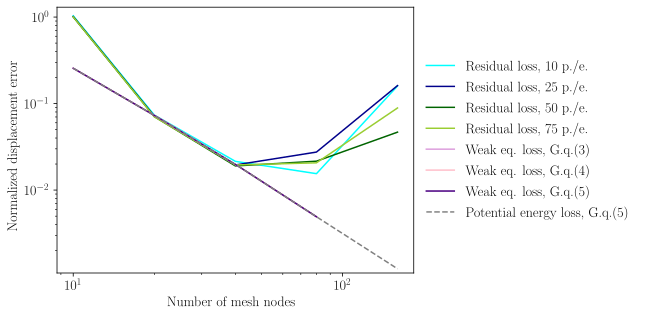

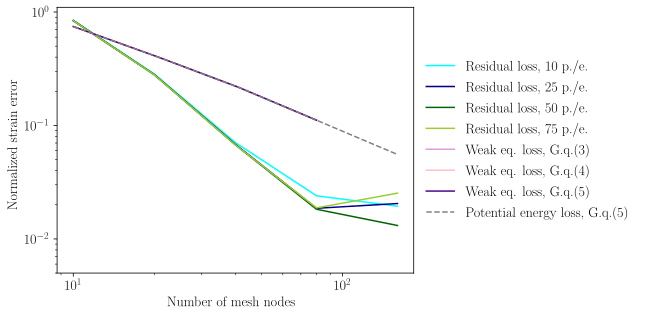

In [11]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution_r, loss_u_r[:,0],'-', color = "cyan", label = 'Residual loss, 10 p./e.')
plt.plot(mesh_resolution_r, loss_u_r[:,1],'-', color = "darkblue", label = 'Residual loss, 25 p./e.')
plt.plot(mesh_resolution_r, loss_u_r[:,2],'-', color = "darkgreen", label = 'Residual loss, 50 p./e.')
plt.plot(mesh_resolution_r, loss_u_r[:,3],'-', color = "yellowgreen", label = 'Residual loss, 75 p./e.')

plt.plot(mesh_resolution_w, loss_u_w[:,0],'-', color = "plum", label = 'Weak eq. loss, G.q.(3)')
plt.plot(mesh_resolution_w, loss_u_w[:,1],'-', color = "pink", label = 'Weak eq. loss, G.q.(4)')
plt.plot(mesh_resolution_w, loss_u_w[:,1],'-', color = "indigo", label = 'Weak eq. loss, G.q.(5)')
plt.plot(mesh_resolution_pe, loss_u_pe,'--', color = "gray", label = 'Potential energy loss, G.q.(5)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0011, 1.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot normalized strain error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution_r, loss_grad_r[:,0],'-', color = "cyan", label = 'Residual loss, 10 p./e.')
plt.plot(mesh_resolution_r, loss_grad_r[:,1],'-', color = "darkblue", label = 'Residual loss, 25 p./e.')
plt.plot(mesh_resolution_r, loss_grad_r[:,2],'-', color = "darkgreen", label = 'Residual loss, 50 p./e.')
plt.plot(mesh_resolution_r, loss_grad_r[:,3],'-', color = "yellowgreen", label = 'Residual loss, 75 p./e.')

plt.plot(mesh_resolution_w, loss_grad_w[:,0],'-', color = "plum", label = 'Weak eq. loss, G.q.(3)')
plt.plot(mesh_resolution_w, loss_grad_w[:,1],'-', color = "pink", label = 'Weak eq. loss, G.q.(4)')
plt.plot(mesh_resolution_w, loss_grad_w[:,1],'-', color = "indigo", label = 'Weak eq. loss, G.q.(5)')
plt.plot(mesh_resolution_pe, loss_grad_pe,'--', color = "gray", label = 'Potential energy loss, G.q.(5)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.005, 1.1])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized strain error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )
plt.show()